In [48]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import metrics
import datetime
import matplotlib.pyplot as plt


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)


def to_sequences(seq_size, obs, target_col):
    x = []
    y = []

    for i in range(len(obs) - seq_size):
        window = obs.iloc[i : (i + seq_size), target_col:].values
        after_window = obs.iloc[i + seq_size, target_col]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)

    x_train = np.array(x)
    y_train = np.array(y)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[3]))

    return x_train, y_train


def backtest(
    pred,
    y_test,
    periods_per_day=10,
    capital=1_000_000,
    mult=10_000,
    contracts=1,
    idx=None,
):
    total = 0
    pnls = []
    counter = 0

    # TODO: Fix to correct date indexing.
    # idx_n = []

    for x in range(len(pred)):
        if pred[x] > 0.0:
            total += y_test[x] * mult * contracts
        elif pred[x] < 0.0:
            total -= y_test[x] * mult * contracts
        if counter % periods_per_day == 0:
            pnls.append(total)
            # idx_n.append(idx[counter])
        counter += 1

    rets = pd.DataFrame(data=pnls, columns=["cum_pnl"])  # , index=idx_n)
    rets["portfolio"] = rets["cum_pnl"] + capital
    rets["pct_pnl"] = rets["portfolio"].pct_change()
    rets = rets.dropna()

    return rets


def perf_summ(data: pd.DataFrame, adj: int = 12, title="Metric") -> pd.DataFrame:
    summary = pd.DataFrame(
        data=data.mean() * adj, index=[title], columns=["Annualized Return"]
    )
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        (data[data < 0]).std() * np.sqrt(adj)
    )

    summary["Skewness"] = data.skew()
    summary["Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    # TODO: Add absolute value/fix Calmar calculation.
    summary["Calmar Ratio"] = np.abs(((data.mean() * adj) / drawdowns.min()))

    return summary.T


periods_per_day = 10

In [49]:
fn = "qm_data_tufv.csv"
df = pd.read_csv(fn, sep=",", na_values=["-1"], index_col=False)
df['Date'] = pd.to_datetime(df['Date'])
target_col = "fut"

df = df.set_index("Date")
df = df.drop("Sum", axis=1)

col = df.pop(target_col)
df.insert(0, col.name, col)

df = df.reset_index(drop=False)

df["CosHour"] = np.cos(2 * np.pi * df["Date"].dt.hour / 24)
df["SinHour"] = np.sin(2 * np.pi * df["Date"].dt.hour / 24)
df["CosDay"] = np.cos(2 * np.pi * df["Date"].dt.day / 30)
df["SinDay"] = np.sin(2 * np.pi * df["Date"].dt.day / 30)
df["SinMonth"] = np.sin(2 * np.pi * df["Date"].dt.month / 12)
df["SinMoth"] = np.sin(2 * np.pi * df["Date"].dt.month / 12)
df["Year"] = df["Date"].dt.year

df = df.dropna()
df = df.drop("Date", axis=1)

df_train = df.iloc[:1000, :]
df_test = df.iloc[900:, :]

x_train = df_train.drop(target_col, axis=1)
y_train = df_train[target_col]

x_train = (x_train - x_train.expanding().mean()) / x_train.expanding().std()
y_train = y_train.iloc[1:]
x_train = x_train.dropna()

x_test = df_test.drop(target_col, axis=1)
y_test = df_test[target_col]

y_train = y_train.to_numpy().reshape((-1, 1))
y_test = y_test.to_numpy().reshape((-1, 1))

df = (df - df.expanding().mean()) / df.expanding().std()

x_train, y_train = to_sequences(100, df_train, 0)
x_test, y_test = to_sequences(100, df_test, 0)

In [50]:
model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]


try:
    with tf.device("/device:GPU:0"):
        model.fit(
            x_train,
            y_train,
            epochs=200,
            batch_size=64,
            callbacks=callbacks,
        )
except:
    model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
    )

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 26)]    0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 100, 26)     52          ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 100, 26)     109594      ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                            

In [51]:
def run_stepped(model, x_test, y_test, step_size, stop_at=None, **model_kwargs):
    stop_at = len(x_test) if stop_at is None else stop_at
    x_test = x_test[:stop_at]
    y_test = y_test[:stop_at]
    preds = []

    for i in range(0, stop_at, step_size):
        # Check if we reached end of data.
        if i + step_size >= stop_at:
            x_step = x_test[i:]
            y_step = y_test[i:]
        else:
            x_step = x_test[i : i + step_size]
            y_step = y_test[i : i + step_size]

        # Predict the data.
        pred = model.predict(x_step)

        # Append to output list.
        preds += pred[:, 0].tolist()

        # Re-fit the model.
        try:
            with tf.device("/device:GPU:0"):
                model.fit(x_step, y_step, **model_kwargs)
        except:
            model.fit(x_step, y_step)
    # At the end, return x/y
    preds_np = np.array(preds)
    return preds_np, y_test[:stop_at]

x, y = run_stepped(
    model, x_test, y_test, step_size=25, epochs=5, batch_size=64, callbacks=callbacks
)

1/1 [==============================] - 0s 226ms/step
Epoch 1/5
1/1 [==============================] - 0s 17ms/step - loss: 6.1555
Epoch 2/5
1/1 [==============================] - 0s 18ms/step - loss: 2.9312
Epoch 3/5
1/1 [==============================] - 0s 16ms/step - loss: 9.2333
Epoch 4/5
1/1 [==============================] - 0s 18ms/step - loss: 14.6175
Epoch 5/5
1/1 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - 0s 17ms/step - loss: 6.9725
Epoch 2/5
1/1 [==============================] - 0s 17ms/step - loss: 14.8677
Epoch 3/5
1/1 [==============================] - 0s 16ms/step - loss: 10.3296
Epoch 4/5
1/1 [==============================] - 0s 17ms/step - loss: 11.7626
Epoch 5/5
1/1 [==============================] - 0s 18ms/step
Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 12.9898
Epoch 2/5
1/1 [==============================] - 0s 16ms/step - loss: 10.0620
Epoch 3/5
1/1 [==============================] 

In [54]:
print(len(x), len(y))

6911 6911


,Window=50
Annualized Return,0.831671
Annualized Volatility,1.264099
Annualized Sharpe Ratio,0.657916
Annualized Sortino Ratio,0.901076
Skewness,0.283552
Kurtosis,5.259519
VaR (0.05),-0.104994
CVaR (0.05),-0.192146
Min,-0.384610
Max,0.431206


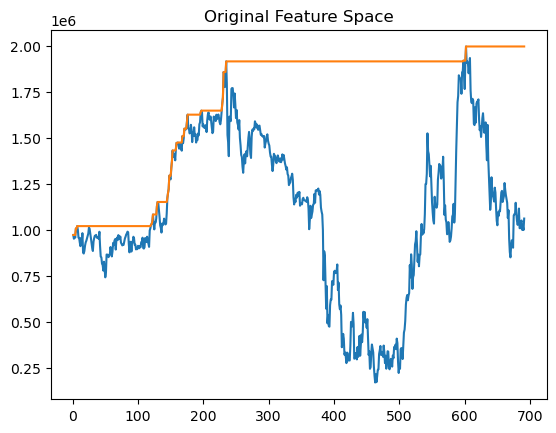

In [55]:
rets = backtest(x, y, periods_per_day=10, mult=1, capital=3.27)
rets = backtest(x, y, periods_per_day=10, mult=10_000, capital=1_000_000,contracts=100)
display(perf_summ(rets["pct_pnl"], adj=252, title="Window=50"))
agg_perf = perf_summ(rets["pct_pnl"], adj=252, title="Transformer")
plt.plot(rets["portfolio"])
plt.plot(rets["portfolio"].cummax())
plt.title("Original Feature Space")
plt.show()

# Correct index needs to still be put in 